# Training using SAC in Brax

In [2]:
#@title Install Brax and some helper modules
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a TPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'TPU'** in the dropdown.

from datetime import datetime
import functools
import os
from os import getcwd
from os.path import join
from IPython.display import HTML, clear_output

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

try:
  import brax
except ImportError:
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

from brax import envs
from brax import jumpy as jp
from brax.io import html
from brax.io import model
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

#### Environment

In [6]:
env_name = "grasp"
env = envs.get_environment(env_name=env_name)
state = env.reset(rng=jp.random_prngkey(seed=0))

HTML(html.render(env.sys, [state.qp]))

# Training

Brax provides out of the box the following training algorithms:

* [Soft actor-critic](https://github.com/google/brax/blob/main/brax/training/agents/sac/train.py)

Trainers take as input an environment function and some hyperparameters, and return an inference function to operate the environment.

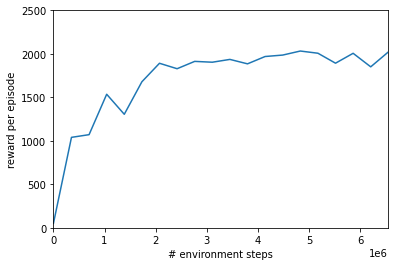

time to jit: 0:00:48.129624
time to train: 0:18:01.294779


In [7]:
train_fn = functools.partial(ppo.train, num_timesteps=600_000_000, num_evals=10, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=20, num_minibatches=32, num_updates_per_batch=2, discounting=0.99, learning_rate=3e-4, entropy_cost=0.001, num_envs=2048, batch_size=256)

max_y = 100
min_y = 0

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

#### Saving and Loading Policies

In [8]:
output_model_path = join(getcwd(), "sac_params")
model.save_params(output_model_path, params)
params = model.load_params(output_model_path)
inference_fn = make_inference_fn(params)

### Visualizing a Policy's Behavior

In [9]:
env = envs.create(env_name=env_name)
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=0)
state = jit_env_reset(rng=rng)
for _ in range(1000):
  rollout.append(state)
  act_rng, rng = jax.random.split(rng)
  act, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_env_step(state, act)

HTML(html.render(env.sys, [s.qp for s in rollout]))